In [1215]:
import fastf1 
import pandas as pd
from fastf1 import plotting, utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.cm import viridis
from urllib.request import urlopen
import json
import requests
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns
from scipy.stats.mstats import winsorize
from matplotlib.colors import LinearSegmentedColormap, to_rgba
import matplotlib.patches as mpatches

In [1216]:
results = pd.read_parquet('2024_fp3_results.parquet')

In [1217]:
results[(results['Season'] == 2020) & results['RoundNumber']== 9]

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,FP3_WindDirection,FP3_WindSpeed,FP2BestLapTime,FP2_AirTemp,FP2_TrackTemp,FP2_Humidity,FP2_Pressure,FP2_Rainfall,FP2_WindDirection,FP2_WindSpeed
index,,,,,,,,,,,,,,,,,,,,,


In [1218]:
results['FP3BestLapTime'] = results['FP3BestLapTime'].dt.total_seconds()
results['FP2BestLapTime'] = results['FP2BestLapTime'].dt.total_seconds()
results['MinQualiTime'] = results['MinQualiTime'].dt.total_seconds()
best_fp3_times = results.groupby(["EventName", "RoundNumber", 'Season'])[["FP3BestLapTime"]].min().rename(columns={"FP3BestLapTime": "FP3BestOverallLapTime"}).reset_index()
best_fp2_times = results.groupby(["EventName", "RoundNumber", 'Season'])[["FP2BestLapTime"]].min().rename(columns={"FP2BestLapTime": "FP2BestOverallLapTime"}).reset_index()
best_quali_times = results.groupby(["EventName", "RoundNumber", 'Season'])[["MinQualiTime"]].min().rename(columns={"MinQualiTime": "MinOverallQualiTime"}).reset_index()
results = pd.merge(results, best_fp3_times, how="left", on=["EventName", "RoundNumber", 'Season'])
results = pd.merge(results, best_fp2_times, how="left", on=["EventName", "RoundNumber", 'Season'])
results = pd.merge(results, best_quali_times, how="left", on=["EventName", "RoundNumber", 'Season'])
results["FP3Delta"] = results["FP3BestLapTime"] - results["FP3BestOverallLapTime"]
results["FP3DeltaFrac"] = results["FP3Delta"] / results["FP3BestLapTime"]
results["FP2Delta"] = results["FP2BestLapTime"] - results["FP2BestOverallLapTime"]
results["FP2DeltaFrac"] = results["FP2Delta"] / results["FP2BestLapTime"]
results["QualiDelta"] = results["MinQualiTime"] - results["MinOverallQualiTime"]
results["QualiDeltaFrac"] = results["QualiDelta"] / results["MinOverallQualiTime"]
results['TeamFP3Delta'] = results.groupby(['Season', 'RoundNumber', 'TeamId'])['FP3Delta'].transform('mean')
print(results.isna().sum())
results = results.dropna(subset=["FP3BestLapTime", "MinQualiTime", "FP3Delta", "QualiDelta", 'FP2BestLapTime', 'FP2Delta'])
results.columns
before = len(results)
results.drop_duplicates(subset=['Season', 'RoundNumber', 'DriverNumber'], inplace=True)
after = len(results)
print(f"Dropped {before - after} duplicate rows")

r2 = results.copy()

DriverNumber       0
BroadcastName      0
Abbreviation       0
DriverId           0
TeamName           0
                  ..
FP2Delta          27
FP2DeltaFrac      27
QualiDelta        16
QualiDeltaFrac    16
TeamFP3Delta       4
Length: 62, dtype: int64
Dropped 0 duplicate rows


In [1219]:
r2.head()

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,FP3BestOverallLapTime,FP2BestOverallLapTime,MinOverallQualiTime,FP3Delta,FP3DeltaFrac,FP2Delta,FP2DeltaFrac,QualiDelta,QualiDeltaFrac,TeamFP3Delta
0,77,V BOTTAS,BOT,bottas,Mercedes,00d2be,mercedes,Valtteri,Bottas,Valtteri Bottas,...,82.292,82.6,80.486,1.130,0.013546,0.048,0.000581,0.112,0.001392,0.5650
1,44,L HAMILTON,HAM,hamilton,Mercedes,00d2be,mercedes,Lewis,Hamilton,Lewis Hamilton,...,82.292,82.6,80.486,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.5650
2,33,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,1e41ff,red_bull,Max,Verstappen,Max Verstappen,...,82.292,82.6,80.486,1.189,0.014243,0.800,0.009592,0.834,0.010362,1.1320
3,5,S VETTEL,VET,vettel,Ferrari,dc0000,ferrari,Sebastian,Vettel,Sebastian Vettel,...,82.292,82.6,80.486,0.264,0.003198,0.873,0.010458,0.704,0.008747,0.3605
4,16,C LECLERC,LEC,leclerc,Ferrari,dc0000,ferrari,Charles,Leclerc,Charles Leclerc,...,82.292,82.6,80.486,0.457,0.005523,1.154,0.013778,0.956,0.011878,0.3605


In [1220]:
r2 = r2[['DriverNumber', 'RoundNumber', 'QualiDelta', 'FP3Delta', 'Season', 'TeamId']]
r2['RoundNumber'] = r2['RoundNumber'] + 1
r2['Prev5QualiDeltas'] = (
    r2.groupby(['DriverNumber', 'Season'])['QualiDelta']
      .transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
)
r2['TeamFP3Delta'] = r2.groupby(['Season', 'RoundNumber', 'TeamId'])['FP3Delta'].transform('mean')
r2['TeamPrevQualiDelta'] = r2.groupby(['Season', 'RoundNumber', 'TeamId'])['QualiDelta'].transform('mean')
r2['Prev5QualiDeltas'] = r2['Prev5QualiDeltas']
r2['PrevQualiDelta'] = r2['QualiDelta']
r2['Prev5QualiDeltas'] = r2['Prev5QualiDeltas'].fillna(r2['FP3Delta'])
r2 = r2[['DriverNumber', 'RoundNumber', 'Prev5QualiDeltas', 'PrevQualiDelta', 'Season', 'TeamPrevQualiDelta']]
results = pd.merge(results, r2, on=['DriverNumber', 'RoundNumber', 'Season'])

In [1221]:
# Winsorize columns
cols = ['FP3Delta', 'FP2Delta', 'QualiDelta', 'Prev5QualiDeltas', 'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta']
results[cols] = results.groupby('RoundNumber')[cols].transform(lambda x: x.clip(upper=4))
results[(results['Season']== 2022) & (results['RoundNumber']== 9)]['MinOverallQualiTime']

635    81.299
636    81.299
637    81.299
638    81.299
639    81.299
640    81.299
641    81.299
642    81.299
643    81.299
644    81.299
645    81.299
646    81.299
647    81.299
648    81.299
649    81.299
650    81.299
651    81.299
652    81.299
653    81.299
Name: MinOverallQualiTime, dtype: float64

# A visualization of deltas throughout a season
This is shown to make sure at atleast one driver has a quali delta of 0 every race and to analyse outlier races which have many Deltas that have been capped to 4

<Axes: xlabel='RoundNumber', ylabel='QualiDelta'>

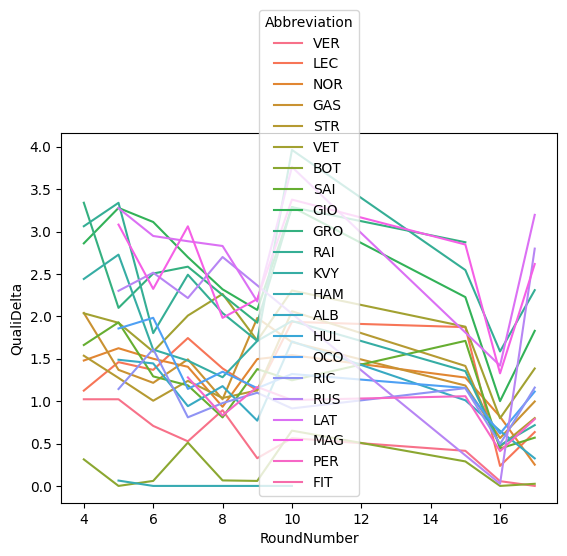

In [1222]:
sns.lineplot(results[(results['Season']== 2020) ], x='RoundNumber', y='QualiDelta', hue='Abbreviation', errorbar= None)

In [1208]:
results[(results['Season']== 2020) & (results['RoundNumber']== 11)]

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,FP3Delta,FP3DeltaFrac,FP2Delta,FP2DeltaFrac,QualiDelta,QualiDeltaFrac,TeamFP3Delta,Prev5QualiDeltas,PrevQualiDelta,TeamPrevQualiDelta


In [1166]:
corr = results['TeamFP3Delta'].corr(results['FP3Delta'])
print(corr)

0.9240473615731846


# Correlations between features
I have plotted the correlations between the quali delta and all of my features to make sure they are all relevant to my prediction.

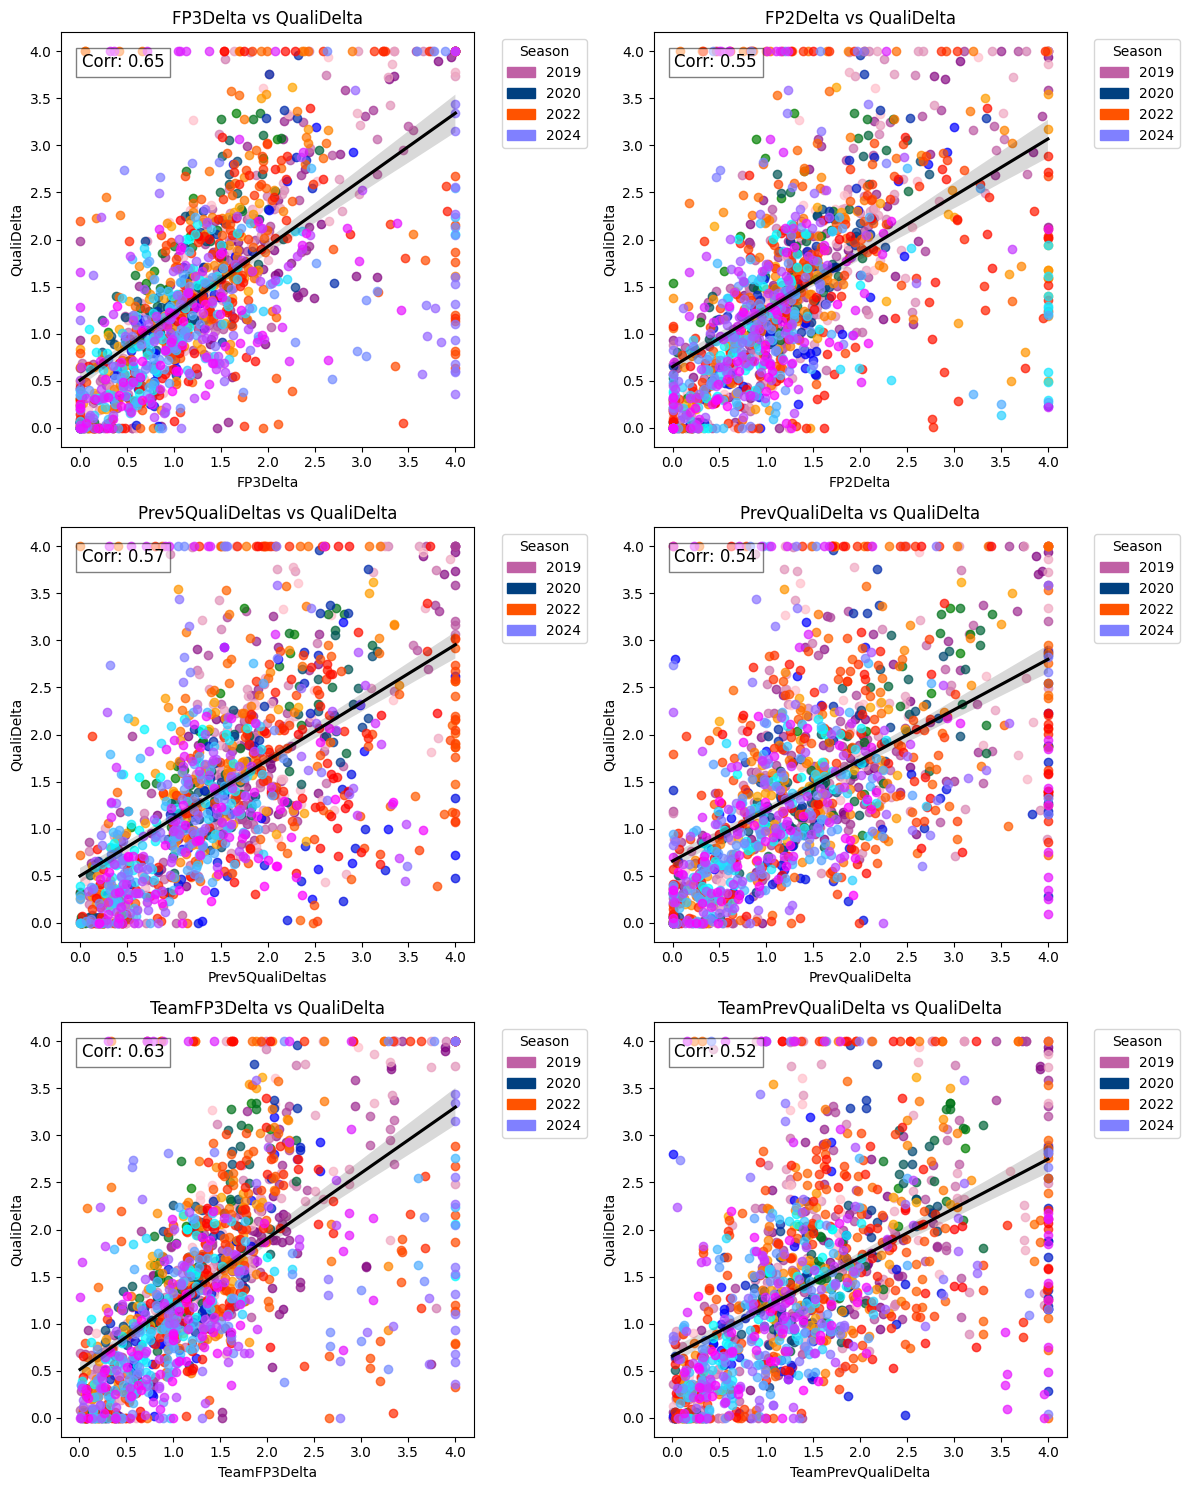

In [1168]:
#results['FP2Delta'] = winsorize(results['FP2Delta'], limits=(0, 0.05))
#results['QualiDelta'] = winsorize(results['QualiDelta'], limits=(0, 0.05))
#results['Prev5QualiDeltas'] = winsorize(results['Prev5QualiDeltas'], limits=(0, 0.05))
#results['PrevQualiDelta'] = winsorize(results['PrevQualiDelta'], limits=(0, 0.05))

results['Quali_Rainfall'] = results['Quali_Rainfall'].fillna(0).astype(int)
results['FP3_Rainfall']   = results['FP3_Rainfall'].fillna(0).astype(int)

# Drop duplicates
results.drop_duplicates(subset=['Season', 'RoundNumber', 'DriverNumber'], inplace=True)

# Define custom colormaps for specific seasons
season_cmaps = {
    2019: LinearSegmentedColormap.from_list("purple_pink", ["purple", "pink"]),
    2020: LinearSegmentedColormap.from_list("green_blue", ["green", "blue"]),
    2022: LinearSegmentedColormap.from_list("orange_red", ["orange", "red"]),
    2024: LinearSegmentedColormap.from_list("cyan_magenta", ["cyan", "magenta"]),
}


# Prepare plots
fig, axes = plt.subplots(3,2, figsize=(12, 15))
plots_info = [
    ('FP3Delta', axes[0, 0], 'FP3Delta vs QualiDelta'),
    ('FP2Delta', axes[0, 1], 'FP2Delta vs QualiDelta'),
    ('Prev5QualiDeltas', axes[1, 0], 'Prev5QualiDeltas vs QualiDelta'),
    ('PrevQualiDelta', axes[1, 1], 'PrevQualiDelta vs QualiDelta'),
    ('TeamFP3Delta', axes[2, 0], 'TeamFP3Delta vs QualiDelta'),
    ('TeamPrevQualiDelta', axes[2, 1], 'TeamPrevQualiDelta vs QualiDelta')
]

# Sort seasons to control order
sorted_seasons = sorted(results['Season'].unique())

for x_col, ax, title in plots_info:
    for season in sorted_seasons:
        season_data = results[results['Season'] == season]
        unique_rounds = sorted(season_data['RoundNumber'].unique())
        cmap = season_cmaps.get(season, plt.cm.viridis)
        colors = cmap(np.linspace(0, 1, len(unique_rounds)))
        round_color_mapping = {round_num: color for round_num, color in zip(unique_rounds, colors)}

        # Plot each round
        for round_num in unique_rounds:
            subset = season_data[season_data['RoundNumber'] == round_num]
            ax.scatter(subset[x_col], subset['QualiDelta'],
                       color=round_color_mapping[round_num],
                       alpha=0.7)

    # Regression line
    sns.regplot(data=results, x=x_col, y='QualiDelta', ax=ax, scatter=False, color='black')

    # Correlation text
    corr = results[x_col].corr(results['QualiDelta'])
    ax.set_title(title)
    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes,
            verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    # Custom legend: only one patch per season
    season_patches = []
    for season in sorted_seasons:
        cmap = season_cmaps.get(season, plt.cm.viridis)
        # Take start and end colors for a gradient representation
        color_start = to_rgba(cmap(0.0))
        color_end = to_rgba(cmap(1.0))
        # Create a patch with a blended color (midpoint)
        mid_color = ((color_start[0]+color_end[0])/2,
                     (color_start[1]+color_end[1])/2,
                     (color_start[2]+color_end[2])/2)
        season_patches.append(mpatches.Patch(color=mid_color, label=str(season)))
    ax.legend(handles=season_patches, title="Season", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Cutting the data
## Track Temperature
By cutting my data by track temperature we can see that as temperature decreases the correlation between the FP3 Delta and the Qualifying Delta also decreases. This is because when the track is very cold in Qualifying it means there is a high different between the track temperature in FP3 and Qualifying causing the correlation to be lower. Because i want to keep the model generalized so i can work with any data and wont have to have poorer results for rookies or stand in drivers.

If i was to use driver profiles, the way i would do it is to take the 

/tmp/ipykernel_264546/1779145202.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('Quali_TrackTempBin')[['QualiDelta', 'FP3Delta']]


Quali_TrackTempBin            
Cool (<24°C)        QualiDelta    0.340673
Mild (24-32°C)      QualiDelta    0.625005
Warm (32-40°C)      QualiDelta    0.821318
Hot (>40°C)         QualiDelta    0.805354
Name: FP3Delta, dtype: float64


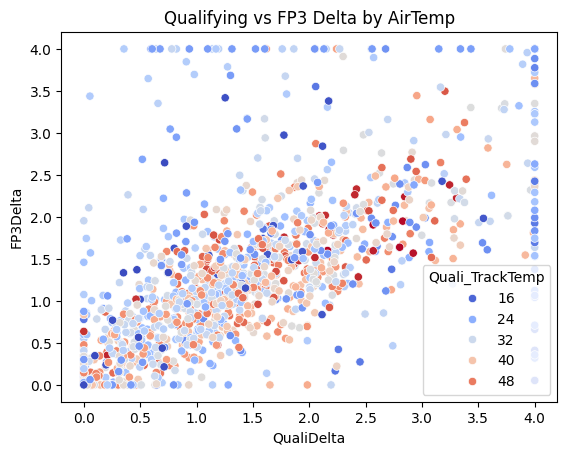

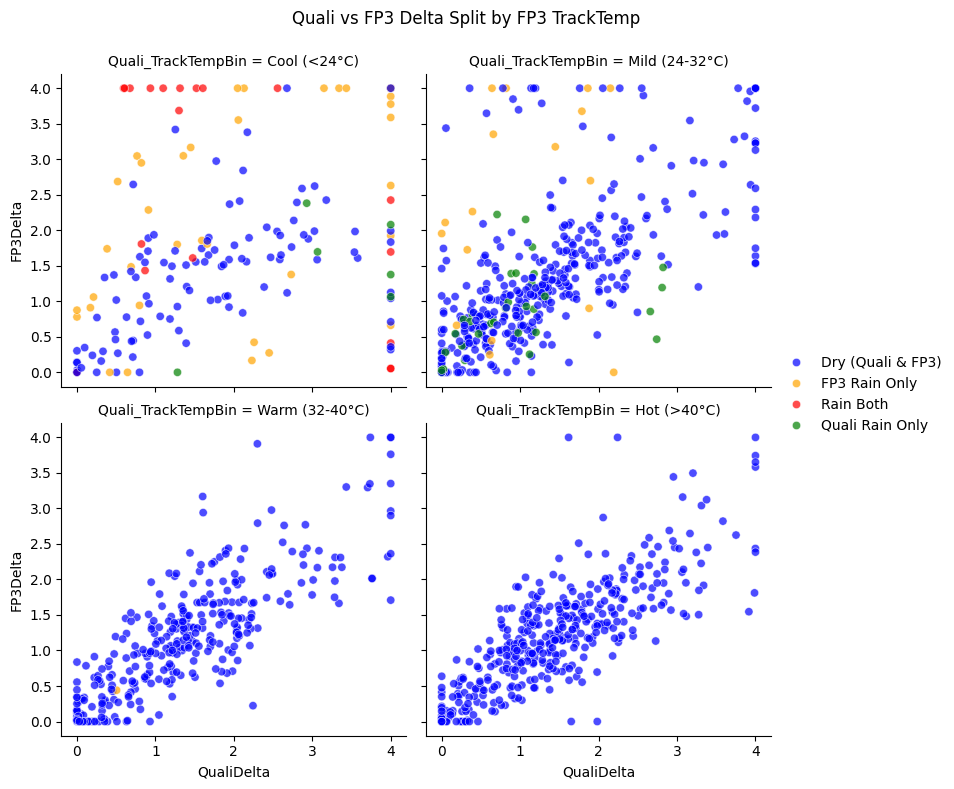

In [1142]:
results['Quali_TrackTempBin'] = pd.cut(
    results['Quali_TrackTemp'],
    bins=[-float('inf'), 24, 32, 40, float('inf')],
    labels=['Cool (<24°C)', 'Mild (24-32°C)', 'Warm (32-40°C)', 'Hot (>40°C)']
)
# Binary columns for rain

# Combine into one categorical column
def rain_category(row):
    if not row['Quali_Rainfall'] and not row['FP3_Rainfall']:
        return 'Dry (Quali & FP3)'
    elif not row['Quali_Rainfall'] and row['FP3_Rainfall']:
        return 'FP3 Rain Only'
    elif row['Quali_Rainfall'] and not row['FP3_Rainfall']:
        return 'Quali Rain Only'
    else:
        return 'Rain Both'

results['RainCategory'] = results.apply(rain_category, axis=1)

corrs = (
    results.groupby('Quali_TrackTempBin')[['QualiDelta', 'FP3Delta']]
    .corr()
    .iloc[0::2, -1]  # extract correlation between the two variables
)
print(corrs)


sns.scatterplot(
    data=results,
    x='QualiDelta',
    y='FP3Delta',
    hue='Quali_TrackTemp',
    palette='coolwarm'
)
plt.title("Qualifying vs FP3 Delta by AirTemp")

palette = {
    'Dry (Quali & FP3)': 'blue',
    'FP3 Rain Only': 'orange',
    'Quali Rain Only': 'green',
    'Rain Both': 'red'
}

g = sns.FacetGrid(results, col='Quali_TrackTempBin', col_wrap=2, height=4)
g.map_dataframe(
    sns.scatterplot,
    x='QualiDelta',
    y='FP3Delta',
    hue='RainCategory',
    palette=palette,
    alpha=0.7
)
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Quali vs FP3 Delta Split by FP3 TrackTemp")
plt.show()


plt.show()


In [1143]:
key_cols = ["RoundNumber", "DriverNumber", 'Season']
x_cols = ['FP3Delta', 'Prev5QualiDeltas', 'FP2Delta', 'PrevQualiDelta', 'TeamFP3Delta', 'TeamPrevQualiDelta']
X = results[key_cols + x_cols].set_index(key_cols)
y = results['QualiDelta']

In [1144]:
groups = results['RoundNumber']  # This ensures all rows of the same race stay together

# Define the splitter
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=2)

# Perform the split
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [1145]:
X_train

FP3Delta  Prev5QualiDeltas  FP2Delta  \
RoundNumber DriverNumber Season                                         
3           44           2019       0.859           0.00000     0.707   
            77           2019       0.000           0.11200     0.000   
            5            2019       0.392           0.70400     0.027   
            33           2019       1.617           0.83400     0.221   
            16           2019       0.418           0.95600     0.828   
...                                   ...               ...       ...   
24          20           2024       0.661           1.11360     0.718   
            30           2024       1.086           1.26975     0.986   
            77           2024       1.046           2.10020     0.713   
            43           2024       1.333           2.71980     1.748   
            11           2024       0.850           2.00100     1.038   

                                 PrevQualiDelta  TeamFP3Delta  \
RoundNumber DriverNumber Season                                 
3           44           2019             0.324        0.4295   
            77           2019             0.390        0.4295   
            5            2019             0.294        0.4050   
            33           2019             0.886        2.0565   
            16           2019             0.000        0.4050   
...                                         ...           ...   
24          20           2024             0.867        0.6605   
            30           2024             1.891        0.9980   
            77           2024             1.211        1.1405   
            43           2024             2.074        1.1390   
            11           2024             0.905        0.6305   

                                 TeamPrevQualiDelta  
RoundNumber DriverNumber Season                      
3           44           2019                0.3570  
            77           2019                0.3570  
            5            2019                0.1470  
            33           2019                1.2730  
            16           2019                0.1470  
...                                             ...  
24          20           2024                1.3945  
            30           2024                1.5710  
            77           2024                1.0960  
            43           2024                1.9720  
            11           2024                0.4525  

[1055 rows x 6 columns]

In [1146]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

#lr = LinearRegression()
#lr.fit(X, y)
#lr_y_pred = lr.predict(X)

#rf = RandomForestRegressor()
#rf.fit(X, y)
#rf_y_pred = rf.predict(X)

In [1147]:
xx = X_test.copy().drop(columns=x_cols)
y_pred = [(a + b) / 2 for a, b in zip(lr_y_pred, rf_y_pred)]
xx["prediction"] = y_pred
print(xx['prediction'])
xx.reset_index()
results

#xx = X.copy().drop(columns=x_cols)
#y_pred = [(a + b) / 2 for a, b in zip(lr_y_pred, rf_y_pred)]
#xx["prediction"] = y_pred
#print(xx['prediction'])
#xx.reset_index()
#results

RoundNumber  DriverNumber  Season
2            44            2019      0.486533
             77            2019      0.760056
             16            2019      0.372980
             33            2019      1.287274
             5             2019      0.219043
                                       ...   
23           27            2024      1.451335
             11            2024      1.769058
             18            2024      1.563294
             43            2024      2.679500
             31            2024      1.777392
Name: prediction, Length: 267, dtype: float64


,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,FP2Delta,FP2DeltaFrac,QualiDelta,QualiDeltaFrac,TeamFP3Delta,Prev5QualiDeltas,PrevQualiDelta,TeamPrevQualiDelta,Quali_TrackTempBin,RainCategory
0,44,L HAMILTON,HAM,hamilton,Mercedes,00d2be,mercedes,Lewis,Hamilton,Lewis Hamilton,...,0.603,0.006741,0.324,0.003687,0.7925,0.00000,0.000,0.0560,Mild (24-32°C),Dry (Quali & FP3)
1,77,V BOTTAS,BOT,bottas,Mercedes,00d2be,mercedes,Valtteri,Bottas,Valtteri Bottas,...,0.711,0.007939,0.390,0.004439,0.7925,1.13000,0.112,0.0560,Mild (24-32°C),Quali Rain Only
2,16,C LECLERC,LEC,leclerc,Ferrari,dc0000,ferrari,Charles,Leclerc,Charles Leclerc,...,0.035,0.000394,0.000,0.000000,0.0845,0.45700,0.956,0.8300,Mild (24-32°C),Quali Rain Only
3,33,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,1e41ff,red_bull,Max,Verstappen,Max Verstappen,...,0.879,0.009797,0.886,0.010084,1.6065,1.18900,0.834,1.6840,Mild (24-32°C),Quali Rain Only
4,5,S VETTEL,VET,vettel,Ferrari,dc0000,ferrari,Sebastian,Vettel,Sebastian Vettel,...,0.000,0.000000,0.294,0.003346,0.0845,0.26400,0.704,0.8300,Mild (24-32°C),Quali Rain Only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1317,20,K MAGNUSSEN,MAG,kevin_magnussen,Haas F1 Team,B6BABD,haas,Kevin,Magnussen,Kevin Magnussen,...,0.718,0.008524,1.037,0.012555,0.6605,1.11360,0.867,1.3945,Mild (24-32°C),Dry (Quali & FP3)
1318,30,L LAWSON,LAW,lawson,RB,6692FF,rb,Liam,Lawson,Liam Lawson,...,0.986,0.011668,0.877,0.010618,0.9980,1.26975,1.891,1.5710,Mild (24-32°C),Dry (Quali & FP3)
1319,77,V BOTTAS,BOT,bottas,Kick Sauber,52e252,sauber,Valtteri,Bottas,Valtteri Bottas,...,0.713,0.008465,0.609,0.007373,1.1405,2.10020,1.211,1.0960,Mild (24-32°C),Dry (Quali & FP3)
1320,43,F COLAPINTO,COL,colapinto,Williams,64C4FF,williams,Franco,Colapinto,Franco Colapinto,...,1.748,0.020501,1.317,0.015945,1.1390,2.71980,2.074,1.9720,Mild (24-32°C),Dry (Quali & FP3)


In [1148]:
# create predicted delta column
results = pd.merge(results, xx['prediction'], on=['RoundNumber', 'DriverNumber', 'Season'])
# create rank of predicted delta
# score actual qualifying position vs predicted qualifying position

In [1149]:
results.dropna(subset=['QualiPosition'], inplace=True)
results['PredictionRank'] = results.groupby(['RoundNumber', 'Season'])['prediction'].rank('min')
max(results['PredictionRank'])

20.0

In [1150]:
rmse = MSE(results['QualiPosition'], results['PredictionRank']) ** 0.5
print(rmse)
pred = results[['QualiPosition', 'PredictionRank']]
pred

3.2751475936665244


,QualiPosition,PredictionRank
0,3.0,3.0
1,4.0,4.0
2,1.0,2.0
3,5.0,5.0
4,2.0,1.0
...,...,...
262,18.0,10.0
263,9.0,17.0
264,15.0,12.0
265,19.0,20.0


In [1151]:
import numpy as np
import pandas as pd

# Define a function to compute RMSE
def rmse(x, y):
    return np.sqrt(np.mean((x - y) ** 2))

# Compute RMSE per event (replace 'Event' with your actual column name)
rmse_per_event = results.groupby(['RoundNumber', 'Season']).apply(
    lambda df: rmse(df['QualiPosition'], df['PredictionRank'])
).reset_index(name='RMSE')
rmse_per_event= rmse_per_event.sort_values('RMSE')
print(rmse_per_event)

# Optional: if you still want the global RMSE across all data
global_rmse = rmse(results['QualiPosition'], results['PredictionRank'])
print(f"Global RMSE: {global_rmse:.3f}")

# Preview just the prediction columns
pred = results[['QualiPosition', 'PredictionRank']]
pred.head()

    RoundNumber  Season      RMSE
10           16    2024  2.182821
9            16    2022  2.212405
2             2    2024  2.333333
4             8    2020  2.366432
3             8    2019  2.470883
11           22    2022  2.774887
5             8    2022  2.880972
7            16    2019  3.162278
1             2    2022  3.324550
0             2    2019  3.361547
6             8    2024  3.605551
12           22    2024  4.000000
13           23    2024  4.483302
8            16    2020  5.082650
Global RMSE: 3.275


/tmp/ipykernel_264546/1470690456.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_event = results.groupby(['RoundNumber', 'Season']).apply(


,QualiPosition,PredictionRank
0,3.0,3.0
1,4.0,4.0
2,1.0,2.0
3,5.0,5.0
4,2.0,1.0


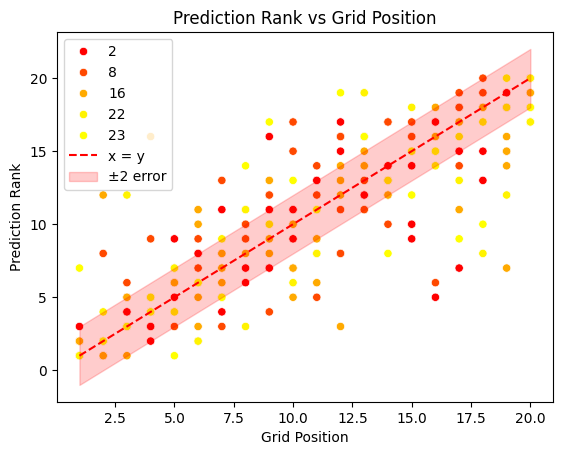

68.16% of predictions are within ±2 of x = y


In [1152]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
ytor = LinearSegmentedColormap.from_list("red_yellow", ["red", "yellow"])
sns.scatterplot(x=results['QualiPosition'], y=results['PredictionRank'], hue=results['RoundNumber'], palette=ytor)

# Define x values
x_vals = np.linspace(results['QualiPosition'].min(), results['QualiPosition'].max(), 100)

# Plot y = x line
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error area
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.2, label='±2 error')

plt.xlabel('Grid Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Grid Position')
plt.legend()
plt.show()

# Count points inside ±2 of y=x
inside_error = ((results['PredictionRank'] >= results['QualiPosition'] - 2) &
                (results['PredictionRank'] <= results['QualiPosition'] + 2))

percentage_inside = inside_error.mean() * 100  # mean() gives fraction of True values
print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")



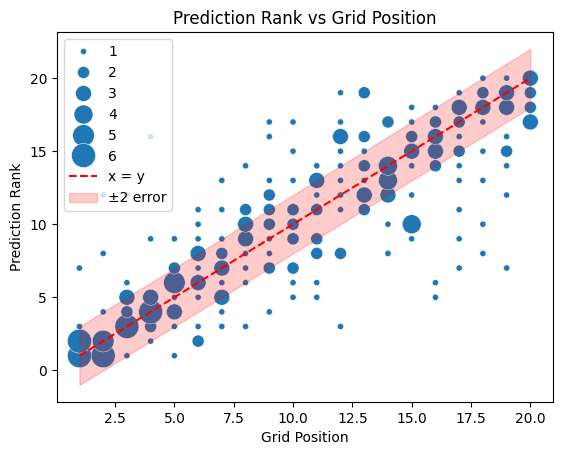

68.16% of predictions are within ±2 of x = y


In [1153]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Group by coordinate pairs and count occurrences
# Example: pick the season of the first occurrence
counts = results.groupby(['QualiPosition', 'PredictionRank']).agg(
    Count=('RoundNumber', 'size'),
    Season=('Season', 'first')
).reset_index()

sns.scatterplot(
    data=counts,
    x='QualiPosition',
    y='PredictionRank',
    size='Count',
    sizes=(20, 300),
    legend=True
)


x_vals = np.linspace(results['QualiPosition'].min(), results['QualiPosition'].max(), 100)

# Plot y = x line
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error area
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.2, label='±2 error')

plt.xlabel('Grid Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Grid Position')
plt.legend()
plt.show()

# Count points inside ±2 of y=x
inside_error = ((results['PredictionRank'] >= results['QualiPosition'] - 2) &
                (results['PredictionRank'] <= results['QualiPosition'] + 2))

percentage_inside = inside_error.mean() * 100  # mean() gives fraction of True values
print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")



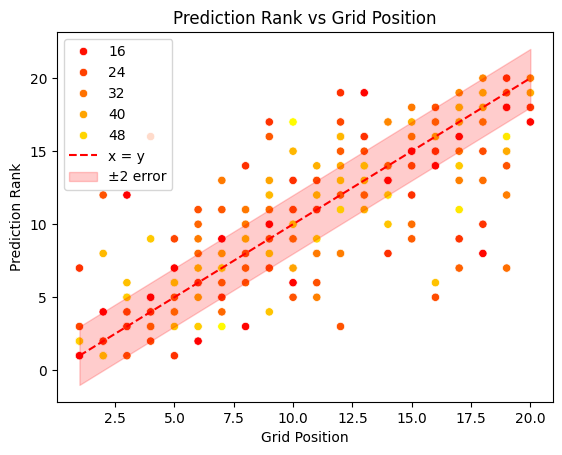

68.16% of predictions are within ±2 of x = y


In [1154]:
# Scatter plot

ytor = LinearSegmentedColormap.from_list("red_yellow", ["red", "yellow"])
sns.scatterplot(x=results['QualiPosition'], y=results['PredictionRank'], hue=results['Quali_TrackTemp'], palette=ytor)
# Define x values
x_vals = np.linspace(results['QualiPosition'].min(), results['QualiPosition'].max(), 100)

# Plot y = x line
plt.plot(x_vals, x_vals, color='red', linestyle='--', label='x = y')

# Add ±2 error area
plt.fill_between(x_vals, x_vals - 2, x_vals + 2, color='red', alpha=0.2, label='±2 error')

plt.xlabel('Grid Position')
plt.ylabel('Prediction Rank')
plt.title('Prediction Rank vs Grid Position')
plt.legend()
plt.show()

# Count points inside ±2 of y=x
inside_error = ((results['PredictionRank'] >= results['QualiPosition'] - 2) &
                (results['PredictionRank'] <= results['QualiPosition'] + 2))

percentage_inside = inside_error.mean() * 100  # mean() gives fraction of True values
print(f"{percentage_inside:.2f}% of predictions are within ±2 of x = y")



In [1155]:
results.columns

Index(['DriverNumber', 'BroadcastName', 'Abbreviation', 'DriverId', 'TeamName',
       'TeamColor', 'TeamId', 'FirstName', 'LastName', 'FullName',
       'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
       'GridPosition', 'Q1', 'Q2', 'Q3', 'Time', 'Status', 'Points', 'Laps',
       'RoundNumber', 'Country', 'EventName', 'Season', 'MinQualiTime',
       'QualiPosition', 'LapEndTime', 'Quali_AirTemp', 'Quali_Humidity',
       'Quali_Pressure', 'Quali_Rainfall', 'Quali_TrackTemp',
       'Quali_WindDirection', 'Quali_WindSpeed', 'FP3BestLapTime',
       'FP3_AirTemp', 'FP3_TrackTemp', 'FP3_Humidity', 'FP3_Pressure',
       'FP3_Rainfall', 'FP3_WindDirection', 'FP3_WindSpeed', 'FP2BestLapTime',
       'FP2_AirTemp', 'FP2_TrackTemp', 'FP2_Humidity', 'FP2_Pressure',
       'FP2_Rainfall', 'FP2_WindDirection', 'FP2_WindSpeed',
       'FP3BestOverallLapTime', 'FP2BestOverallLapTime', 'MinOverallQualiTime',
       'FP3Delta', 'FP3DeltaFrac', 'FP2Delta', 'FP2DeltaFrac', 'Quali